In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sys
import hashlib
import json
import polars as pl

sys.path.append(".")
sys.path.append("..")

In [2]:
# df  = pd.read_csv('../data/resume_job_matching_dataset.csv')
# df["match_score"] = df["match_score"] *2
# df["data_id"] = "id_" + df.index.astype(str)
# df
# df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

# df_train.to_csv('../data/train.csv', index=False)
# df_test.to_csv('../data/test.csv', index=False)

In [3]:
# import json
# outputs = []
# paths = [
#     '../data/output.json',
#     '../data/output2.json',
# ]
# for path in paths:
#     outputs.extend(
#         json.load(open(path, "r"))
#     )
# print(
#     *outputs, sep="\n"
# )

In [ ]:
df = pd.read_csv("../data/resume_job_matching_dataset.csv")
df["match_score"] = df["match_score"] * 2
df

,job_description,resume,match_score
0,"Data Analyst needed with experience in SQL, Ex...","Experienced professional skilled in SQL, Power...",8
1,Data Scientist needed with experience in Stati...,"Experienced professional skilled in Python, De...",8
2,Software Engineer needed with experience in Sy...,"Experienced professional skilled in wait, Git,...",10
3,"ML Engineer needed with experience in Python, ...","Experienced professional skilled in return, De...",8
4,Software Engineer needed with experience in RE...,"Experienced professional skilled in REST APIs,...",10
...,...,...,...
9995,Product Manager needed with experience in Scru...,Experienced professional skilled in commercial...,8
9996,Data Analyst needed with experience in Tableau...,"Experienced professional skilled in financial,...",4
9997,Product Manager needed with experience in Prod...,Experienced professional skilled in internatio...,4
9998,Product Manager needed with experience in Agil...,"Experienced professional skilled in role, Agil...",4


# Evaluation

In [ ]:
df_test = pl.read_csv("../data/test.csv")
df_train = pl.read_csv("../data/train.csv")

In [ ]:
# outputs = json.load(open('../outputs.jsonl', "r"))
df_outputs = {}
output_paths = {
    "train": "../outputs/outputs_train.jsonl",
    "test": "../outputs/outputs_test.jsonl",
}
for name_set, path in output_paths.items():
    outputs = []
    with open(path, "r") as f:
        lines = f.readlines()
        for line in lines:
            jsonline = json.loads(line)
            if not isinstance(jsonline, dict):
                continue
            outputs.append(jsonline)
    df = pl.DataFrame(outputs)
    print(name_set, len(df))
    df_outputs[name_set] = df

train 6999
test 2966


In [ ]:
print(df_train.join(df_outputs["train"], on="data_id", how="anti"))

print(df_test.join(df_outputs["test"], on="data_id", how="anti"))

shape: (1, 4)
┌─────────────────────────────────┬─────────────────────────────────┬─────────────┬─────────┐
│ job_description                 ┆ resume                          ┆ match_score ┆ data_id │
│ ---                             ┆ ---                             ┆ ---         ┆ ---     │
│ str                             ┆ str                             ┆ i64         ┆ str     │
╞═════════════════════════════════╪═════════════════════════════════╪═════════════╪═════════╡
│ Data Analyst needed with exper… ┆ Experienced professional skill… ┆ 6           ┆ id_983  │
└─────────────────────────────────┴─────────────────────────────────┴─────────────┴─────────┘
shape: (51, 4)
┌─────────────────────────────────┬─────────────────────────────────┬─────────────┬─────────┐
│ job_description                 ┆ resume                          ┆ match_score ┆ data_id │
│ ---                             ┆ ---                             ┆ ---         ┆ ---     │
│ str                          

In [6]:
df_gts = {
    # "train": df_train,
    "test": df_test
}
thresholds = [0, 1, 2, 3]
for name_set in df_gts.keys():
    df_output = df_outputs[name_set]
    df_gt = df_gts[name_set]
    print(name_set)
    df = df_gt.join(df_output, on="data_id", how="inner").with_columns(
        (pl.col("match_score") - pl.col("score")).abs().alias("abs_error")
    )
    for threshold in thresholds:
        preds = df.with_columns(
            (
                ((pl.col("match_score") - pl.col("score")).abs() <= threshold)
                .cast(pl.Int8)
                .alias("correct")
            )
        )

        accuracy = round(sum(preds["correct"]) / len(preds), 2)
        print(f"Threshold {threshold} - Acc: {accuracy}")
    
    print("MAE:", round(df["abs_error"].mean(), 2))

test
Threshold 0 - Acc: 0.13
Threshold 1 - Acc: 0.41
Threshold 2 - Acc: 0.6
Threshold 3 - Acc: 0.78
MAE: 2.28


In [ ]:
df_concat = df_gt.join(df_output, on="data_id", how="inner").rename(
    {"match_score": "label"}
)

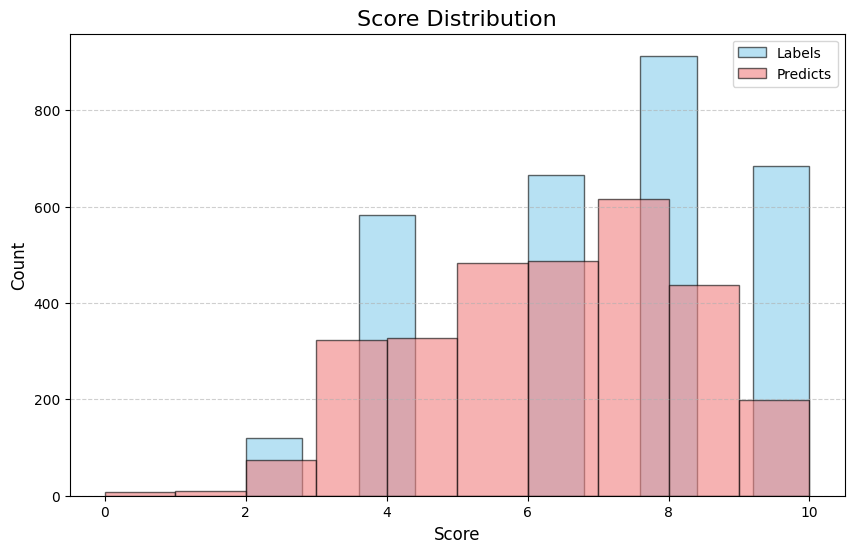

In [ ]:
import matplotlib.pyplot as plt

num_bins = 10
title = "Score Distribution"
labels = df_concat["label"]
predicts = df_concat["score"]
# Create a figure for the plot
plt.figure(figsize=(10, 6))

# Plot the histogram for labels
plt.hist(
    labels, bins=num_bins, color="skyblue", edgecolor="black", alpha=0.6, label="Labels"
)

# Plot the histogram for predicts
plt.hist(
    predicts,
    bins=num_bins,
    color="lightcoral",
    edgecolor="black",
    alpha=0.6,
    label="Predicts",
)

# Add titles, labels, and a legend
plt.title(title, fontsize=16)
plt.xlabel("Score", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend()

# Add a grid for better readability
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show the plot
plt.show()

In [ ]:
df_concat.rename({"match_score": "label"}).write_csv("result1.csv")

# Dataset 2

In [7]:
df_meta = pl.DataFrame(json.load(open("../data/dataset/df_final_score.json")))
df_meta = (
    df_meta.with_row_index()
    .with_columns(_id=pl.concat_str([pl.lit("id_"), pl.col("index")]))
    .drop("index")
)
df_meta.write_csv("../data/dataset/meta.csv")

In [8]:
# outputs = json.load(open('../outputs.jsonl', "r"))
df_test = None
path = "../outputs/collector/scores.jsonl"
outputs = []
with open(path, "r") as f:
    lines = f.readlines()
    for line in lines:
        jsonline = json.loads(line)
        if not isinstance(jsonline, dict):
            continue
        outputs.append(jsonline)
df_test = pl.DataFrame(outputs).rename({"score": "match_score"})
print(len(df_test))
# (
#     df_meta
#     .join(
#         df_test,
#         left_on="_id",
#         right_on="id",
#         how="anti"
#     )
#     .write_csv("error.csv")
# )

88


In [10]:
thresholds = [0, 1, 2, 3]
df =  df_meta.join(df_test, left_on="_id", right_on="id", how="inner").with_columns(
        (pl.col("match_score") - pl.col("Score")).abs().alias("abs_error"))
for threshold in thresholds:
    preds = (
        df
        .with_columns(
            (
                ((pl.col("match_score") - pl.col("Score")).abs() <= threshold)
                .cast(pl.Int8)
                .alias("correct")
            )
        )["correct"]
        .to_list()
    )
    accuracy = round(sum(preds) / len(preds), 2)
    print(f"Threshold {threshold} - Acc: {accuracy}")
print("MAE:", round(df["abs_error"].mean(), 2))

Threshold 0 - Acc: 0.1
Threshold 1 - Acc: 0.44
Threshold 2 - Acc: 0.61
Threshold 3 - Acc: 0.8
MAE: 2.23


In [ ]:
df_concat2 = df_meta.join(df_test, left_on="_id", right_on="id", how="inner")
df_concat2 = df_concat2.rename({"Score": "label", "match_score": "score"})
# .write_csv("result2.csv")
# df_concat2

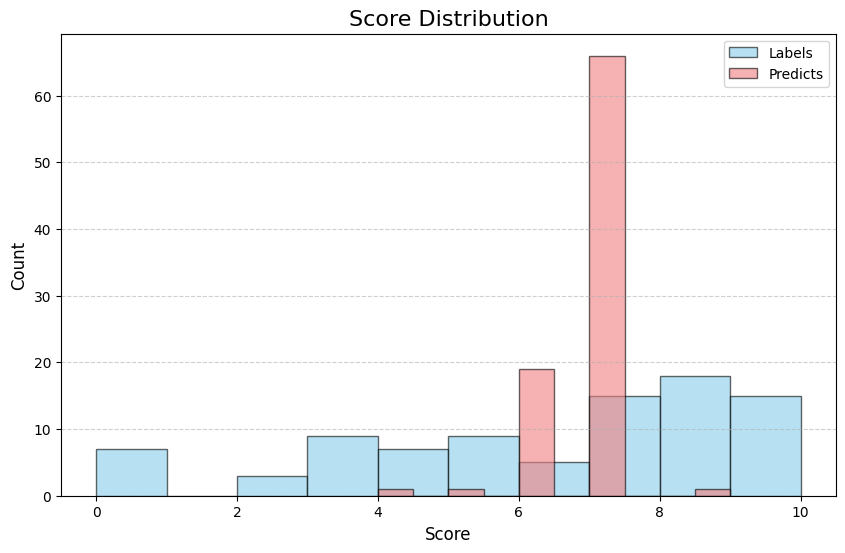

In [ ]:
import matplotlib.pyplot as plt

num_bins = 10
title = "Score Distribution"
labels = df_concat2["label"]
predicts = df_concat2["score"]
# Create a figure for the plot
plt.figure(figsize=(10, 6))

# Plot the histogram for labels
plt.hist(
    labels, bins=num_bins, color="skyblue", edgecolor="black", alpha=0.6, label="Labels"
)

# Plot the histogram for predicts
plt.hist(
    predicts,
    bins=num_bins,
    color="lightcoral",
    edgecolor="black",
    alpha=0.6,
    label="Predicts",
)

# Add titles, labels, and a legend
plt.title(title, fontsize=16)
plt.xlabel("Score", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend()

# Add a grid for better readability
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show the plot
plt.show()

In [9]:
# df_pred = pd.DataFrame(data)
# (
#     df_train.iloc[indexes].reset_index(drop=True)
#     .join(df_pred)
# )

In [30]:
import os

folders = [
    "AI_Engineer",
    "Software_Engineer",
    "Data_Scientist",
    "Data_Engineer",
    "Sale_Marketing",
    "Data_Analyst",
]
path = "../data/dataset"
for folder in folders:
    cv_path = os.path.join(path, folder)
    for cv_file in os.listdir(cv_path):
        new_file = folder + "_" + cv_file
        old_path = os.path.join(cv_path, cv_file)
        new_path = os.path.join(path, "CV", new_file)
        os.system(f"cp {old_path} {new_path}")

In [ ]:
contents = {}
with open(
    "/home/vhbduy/msc/llm-resume-evaluation/outputs/collector/outputs.jsonl", "r"
) as f:
    lines = f.readlines()
    for line in lines:
        jsonline = json.loads(line)
        if not isinstance(jsonline, dict):
            continue
        contents.update(jsonline)

In [ ]:
json.dump(
    contents,
    open(
        "/home/vhbduy/msc/llm-resume-evaluation/outputs/collector/parsed_contents.json",
        "w",
    ),
)